In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from pathlib import Path
from typing import Union, Callable
import pandas as pd
import torch
import numpy.typing as npt
import torchvision
import imageio.v3 as iio

class RvFDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            split: str = "train",
            data_directory : Union[str, Path] = "data/rvf140k",
            preprocessor : Callable[[npt.ArrayLike], torch.Tensor] = None
    ):
        self.data_directory = Path(data_directory)
        self.metadata = pd.read_csv(self.data_directory / f"{split}.csv")

        if preprocessor is None:
            self.preprocessor = torchvision.transforms.ToTensor()
        else:
            self.preprocessor = preprocessor

    def __len__(self) -> int:
        return len(self.metadata)

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        image_metadata = self.metadata.iloc[index]
        path = self.data_directory / image_metadata["path"]
        image = self.preprocessor(iio.imread(path))
        return image, image_metadata["label"]

In [3]:
# One time code to calculate the mean and std of the train_dataset

# import torchvision.transforms.v2 as v2

# mean = torch.zeros((3,))
# variance = torch.zeros((3,))
# tensor_converter = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

# for image, _ in train_dataset:
#     mean += tensor_converter(image).mean(dim=(1, 2))
# mean /= len(train_dataset)

# for image, _ in train_dataset:
#     image = tensor_converter(image)
#     variance += ((image - mean.view(3, 1, 1))**2).mean(dim=(1,2))

# std = torch.sqrt(variance / len(train_dataset))

# print(mean, std)

In [4]:
import torchvision.transforms.v2 as v2

MEAN = [0.5186, 0.4246, 0.3793]
STD = [0.2790, 0.2535, 0.2542]

preprocessor = v2.Compose([
    v2.ToImage(),
    v2.Resize((128, 128)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = MEAN, std = STD),
])

In [5]:
train_dataset = RvFDataset("train", data_directory="../data/rvf140k", preprocessor=preprocessor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = RvFDataset("valid", data_directory="../data/rvf140k", preprocessor=preprocessor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    
    # define the conv layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )

    # Useful: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d
    # H_out = H_in + 2p - 2 --> p = 1 if H_out = H_in
    
    # Easy to calculate output
    # 32 > 16 > 8 > 4

    # define the linear layers
    self.fc1 = nn.Linear(16384, 256)
    self.fc2 = nn.Linear(256, K)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x

In [7]:
K = 2
model = CNN(K)

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)
model.to(device)

mps


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.1)

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4267602


In [11]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    # Switch to eval mode to change the behavior of the dropout layer
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [12]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, val_loader, epochs=5)

Epoch 1/5, Train Loss: 0.6363,       Test Loss: 0.5585, Duration: 0:07:03.982762
Epoch 2/5, Train Loss: 0.4450,       Test Loss: 0.3929, Duration: 0:06:45.477095
Epoch 3/5, Train Loss: 0.3356,       Test Loss: 0.2800, Duration: 0:06:40.351656
Epoch 4/5, Train Loss: 0.2752,       Test Loss: 0.2949, Duration: 0:06:42.121932
Epoch 5/5, Train Loss: 0.2559,       Test Loss: 0.2773, Duration: 0:06:41.340626


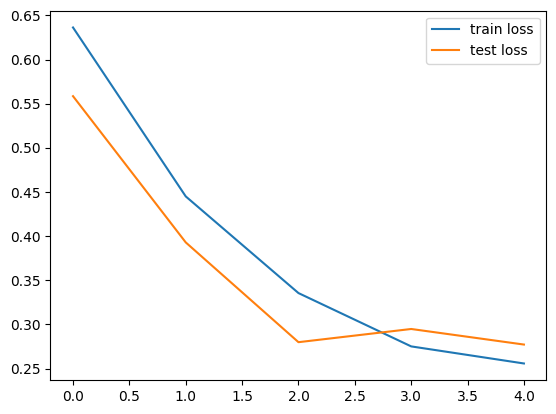

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [14]:
model.eval()
n_correct = 0.
n_total = 0.

for inputs, targets in train_dataset:
  inputs = torch.unsqueeze(torch.tensor(inputs), 0)
  targets = torch.unsqueeze(torch.tensor(targets), 0)
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct = 0.
n_total = 0.

for inputs, targets in val_dataset:
  inputs = torch.unsqueeze(torch.tensor(inputs), 0)
  targets = torch.unsqueeze(torch.tensor(targets), 0)
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

/var/folders/t_/zrszv1g95pg_t0_0zg0y_3l00000gn/T/ipykernel_59374/2194220118.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.unsqueeze(torch.tensor(inputs), 0)
/var/folders/t_/zrszv1g95pg_t0_0zg0y_3l00000gn/T/ipykernel_59374/2194220118.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.unsqueeze(torch.tensor(inputs), 0)


Train acc: 0.8948, Test acc: 0.8829


In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[8927 1073]
 [1283 8717]]


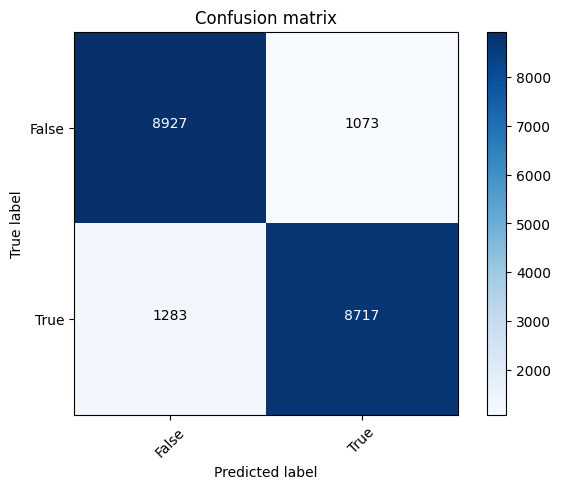

In [16]:
# Assuming `model`, `device`, and `val_loader` are already defined
p_test = np.array([])
y_test = np.array([])

# Iterate over the validation dataset and gather predictions and ground truth labels
for inputs, targets in val_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    
    # Get model predictions
    _, predictions = torch.max(outputs, 1)
    
    # Append the predictions and ground truth to the arrays
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))  # Model predictions
    y_test = np.concatenate((y_test, targets.cpu().numpy()))      # Ground truth labels

# Compute confusion matrix for binary classification (0/1, False/True)
cm = confusion_matrix(y_test, p_test)

# Assuming you already have a plotting function for confusion matrix
# Simply call your existing plot function (replace with your actual function)
plot_confusion_matrix(cm, classes=['False', 'True'])

In [17]:
from torchsummary import summary
# Move model to CPU temporarily for summary
model.cpu()

# Run summary on the CPU
summary(model, (3, 128, 128))

# Move the model back to the MPS device after summary
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
       BatchNorm2d-3         [-1, 16, 128, 128]              32
            Conv2d-4         [-1, 16, 128, 128]           2,320
              ReLU-5         [-1, 16, 128, 128]               0
       BatchNorm2d-6         [-1, 16, 128, 128]              32
         MaxPool2d-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,640
              ReLU-9           [-1, 32, 64, 64]               0
      BatchNorm2d-10           [-1, 32, 64, 64]              64
           Conv2d-11           [-1, 32, 64, 64]           9,248
             ReLU-12           [-1, 32, 64, 64]               0
      BatchNorm2d-13           [-1, 32, 64, 64]              64
        MaxPool2d-14           [-1, 32,

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_